### Libraries used 

In [7]:
# Necessary imports for this notebook
import os
import collections
import numpy as np
import pandas as pd
import datetime
import time
import ccard as ccd
import random
import faker 
from faker import Faker
from collections import OrderedDict
#from pandarallel import pandarallel

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

locales=OrderedDict([('es_ES', 3)])
faker= Faker(locales)
#pandarallel.initialize(progress_bar=True)
Faker.seed(0)
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

### Sender Profile Generation

In [10]:
def generate_customer_profiles_table(n_customers, random_state=0):
    np.random.seed(random_state)
        
    customer_id_properties=[]
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        #acc_id=np.random.randint(1,n_customers)
        acc_id=faker['es_ES'].iban()
        name=faker['es_ES'].first_name()
        last_name=faker['es_ES'].last_name()
        dob=faker.date_of_birth(minimum_age=18, maximum_age=27)
        mean_amount = np.random.uniform(0.50,1000) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        ip=faker.ipv4()
        customer_id_properties.append([customer_id, acc_id, name, last_name,dob, ip,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['SENDER_ID','iban','name','last_name', 'dob','ip',                                                                            
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table

#### Testing sender generating function

In [11]:
n_customers = 4
customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
customer_profiles_table

,SENDER_ID,iban,name,last_name,dob,ip,mean_amount,std_amount,mean_nb_tx_per_day
0,0,ES1266048764759382421948,Julieta,Collado,1999-07-11,68.184.50.44,549.039097,274.519549,2.860757
1,1,ES3757815659387784080160,Emma,Uriarte,1999-12-01,117.52.9.124,602.961994,301.480997,2.179533
2,2,ES4413933287115871484185,Ofelia,Frutos,2003-07-23,156.122.179.65,423.942972,211.971486,2.583576
3,3,ES0719659342320947112201,Tomasa,Posada,2003-03-04,124.241.39.93,437.868418,218.934209,3.567092


In [12]:
def generate_receiver_profiles_table(n_receiver, random_state=0):
    locales=OrderedDict([('es_ES', 3), ('it_IT',1), ('pt_PT',2)])
    faker=Faker(locales)
    np.random.seed(random_state)
        
    receiver_id_properties=[]
    # Generate terminal properties from random distributions 
    for receiver_id in range(n_receiver):

        acc_id=faker.iban()
        name=faker.first_name()
        last_name=faker.last_name()
        receiver_id_properties.append([receiver_id, acc_id, name, last_name])
                                       
    receiver_profiles_table = pd.DataFrame(receiver_id_properties, columns=['RECEIVER_ID','iban','name','last_name'])
    
    return receiver_profiles_table

In [13]:
n_receivers = 5
receiver_profiles_table = generate_receiver_profiles_table(n_receivers, random_state = 0)
receiver_profiles_table

,RECEIVER_ID,iban,name,last_name
0,0,PT45969477515917953304135,Sandro,Barrios
1,1,ES9323098910139916151090,Gil,Morais
2,2,ES3800869141314562087091,Adriana,Palmer
3,3,PT63792302258419720769845,Gema,Alberola
4,4,ES2715084237594599246610,Ilaria,Heras


In [14]:
def generate_transactions_table(customer_profile, receiver_profiles_table, start_date = "2017-09-05", nb_days=10):
    customer_transactions = []
    
    random.seed(int(customer_profile.SENDER_ID))
    np.random.seed(int(customer_profile.SENDER_ID))
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)

        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                receiver_id = random.choice(receiver_profiles_table.RECEIVER_ID)
                iban= receiver_profiles_table.loc[receiver_id,'iban'] 
                #customer_transactions.append([time_tx+day*86400, day,customer_profile.SENDER_ID,customer_profile.iban, receiver_id,iban])
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                        
                    customer_transactions.append([time_tx+day*86400, day,customer_profile.SENDER_ID,
                                                      customer_profile.iban, receiver_id,iban,amount]) 
                                                                  
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'SENDER_ID','SENDER_IBAN','RECEIVER_ID','RECEIVER_IBAN','TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','SENDER_ID','SENDER_IBAN','RECEIVER_ID','RECEIVER_IBAN','TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions  

In [15]:
transaction_table_customer_0=generate_transactions_table(customer_profiles_table.iloc[0], receiver_profiles_table,
                                                         start_date = "2015-09-05", 
                                                         nb_days = 5)
transaction_table_customer_0

,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2015-09-05 07:19:05,0,ES1266048764759382421948,3,PT63792302258419720769845,1089.82,26345,0
1,2015-09-05 19:02:02,0,ES1266048764759382421948,3,PT63792302258419720769845,410.17,68522,0
2,2015-09-05 18:00:16,0,ES1266048764759382421948,2,ES3800869141314562087091,681.99,64816,0
3,2015-09-06 15:13:02,0,ES1266048764759382421948,4,ES2715084237594599246610,285.29,141182,1
4,2015-09-06 14:05:38,0,ES1266048764759382421948,3,PT63792302258419720769845,558.22,137138,1
5,2015-09-06 15:46:51,0,ES1266048764759382421948,3,PT63792302258419720769845,119.83,143211,1
6,2015-09-06 08:51:06,0,ES1266048764759382421948,2,ES3800869141314562087091,482.56,118266,1
7,2015-09-06 20:24:47,0,ES1266048764759382421948,3,PT63792302258419720769845,457.61,159887,1
8,2015-09-07 12:15:47,0,ES1266048764759382421948,2,ES3800869141314562087091,1039.74,216947,2
9,2015-09-07 08:50:09,0,ES1266048764759382421948,4,ES2715084237594599246610,597.19,204609,2


In [16]:
transactions_df=customer_profiles_table.groupby('SENDER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], receiver_profiles_table, nb_days=5)).reset_index(drop=True)
transactions_df

,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2017-09-05 07:19:05,0,ES1266048764759382421948,3,PT63792302258419720769845,1089.82,26345,0
1,2017-09-05 19:02:02,0,ES1266048764759382421948,3,PT63792302258419720769845,410.17,68522,0
2,2017-09-05 18:00:16,0,ES1266048764759382421948,2,ES3800869141314562087091,681.99,64816,0
3,2017-09-06 15:13:02,0,ES1266048764759382421948,4,ES2715084237594599246610,285.29,141182,1
4,2017-09-06 14:05:38,0,ES1266048764759382421948,3,PT63792302258419720769845,558.22,137138,1
...,...,...,...,...,...,...,...,...
57,2017-09-09 16:13:41,3,ES0719659342320947112201,4,ES2715084237594599246610,285.15,404021,4
58,2017-09-09 11:30:54,3,ES0719659342320947112201,4,ES2715084237594599246610,601.06,387054,4
59,2017-09-09 06:10:23,3,ES0719659342320947112201,3,PT63792302258419720769845,723.33,367823,4
60,2017-09-09 16:52:02,3,ES0719659342320947112201,3,PT63792302258419720769845,976.09,406322,4


In [17]:
def generate_dataset(n_customers=1000, n_receivers = 5000, nb_days=50, start_date="2017-09-05"):
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    receiver_profiles_table = generate_receiver_profiles_table(n_receivers, random_state = 1)
    print("Time to generate receiver profiles table: {0:.2}s".format(time.time()-start_time))
    
    #start_time=time.time()
    #x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    #customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    
    # With Pandarallel
    #customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_closest_terminals(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    #customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    #print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('SENDER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], receiver_profiles_table, nb_days=nb_days)).reset_index(drop=True)
    # With Pandarallel
    #transactions_df=customer_profiles_table.groupby('SENDER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0],receiver_profiles_table, nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, receiver_profiles_table, transactions_df)  

In [18]:
(customer_profiles_table, receiver_profiles_table, transactions_df)=\
    generate_dataset(n_customers = 6000, 
                     n_receivers = 7000, 
                     nb_days=1300, 
                     start_date="2017-09-05")

Time to generate customer profiles table: 2.0s
Time to generate receiver profiles table: 1.7s
Time to generate transactions: 2.8e+03s


In [19]:
customer_profiles_table

,SENDER_ID,iban,name,last_name,dob,ip,mean_amount,std_amount,mean_nb_tx_per_day
0,0,ES5937696069602714278789,Marisol,Abad,1994-11-28,25.252.97.147,549.039097,274.519549,2.860757
1,1,ES5370638120665030089131,Ema,Fiol,1999-05-24,126.93.76.23,602.961994,301.480997,2.179533
2,2,ES6617610471428512400034,Celestina,Miranda,2000-06-27,204.86.6.120,423.942972,211.971486,2.583576
3,3,ES3697765823694022455515,Melisa,Araujo,1994-12-13,124.153.0.132,437.868418,218.934209,3.567092
4,4,ES9494568241730428146546,César,Cabezas,2003-10-15,223.43.11.205,963.680929,481.840465,1.533766
...,...,...,...,...,...,...,...,...,...
5995,5995,ES4377193194034183344563,Jerónimo,Vendrell,1999-08-10,154.85.188.34,448.614209,224.307104,2.342810
5996,5996,ES7323883317674031778294,Lupe,Zamorano,2002-10-25,43.178.210.72,177.021771,88.510885,2.898712
5997,5997,ES3361701590499421993542,Roque,Fabregat,1996-08-14,155.197.20.102,939.232559,469.616279,1.993922
5998,5998,ES4312807917465071123036,Miguel Ángel,Baños,1995-03-25,213.40.192.226,122.200835,61.100418,3.373924


In [20]:
#print(customer_profiles_table.style.to_latex(label='SENDERS TABLE'))

In [21]:
#print(receiver_profiles_table.style.to_latex(label='RECEIVERS TABLE'))

In [22]:
transactions_df.shape

(14971325, 9)

In [23]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,0,2017-09-05 00:00:31,1784,ES9759829751721016132037,3122,ES8948173133800584835158,337.89,31,0
1,1,2017-09-05 00:01:42,5199,ES0440942338489897396095,2949,ES8175034922683534700272,246.18,102,0
2,2,2017-09-05 00:01:59,3305,ES8357786516953523958581,4121,ES5738140145327875933422,842.95,119,0
3,3,2017-09-05 00:03:12,53,ES4932583861269516637636,1769,ES4140920575646842478395,501.8,192,0
4,4,2017-09-05 00:05:13,5290,ES9195762557442068820105,5292,PT52809944334055867249256,1352.13,313,0
...,...,...,...,...,...,...,...,...,...
14971320,14971320,2021-03-27 23:55:20,2918,ES2773122558832438113049,1946,ES7909479305218831430209,308.28,112319720,1299
14971321,14971321,2021-03-27 23:55:32,3450,ES4138200103980207933600,5189,IT32X1833657608933339558926,2.45,112319732,1299
14971322,14971322,2021-03-27 23:57:06,5038,ES8296015840077148604192,4423,PT98879803137106943747755,656.69,112319826,1299
14971323,14971323,2021-03-27 23:58:36,797,ES6046550614624604872552,5297,PT82474840602760796005646,98.95,112319916,1299


In [24]:
%%capture

distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

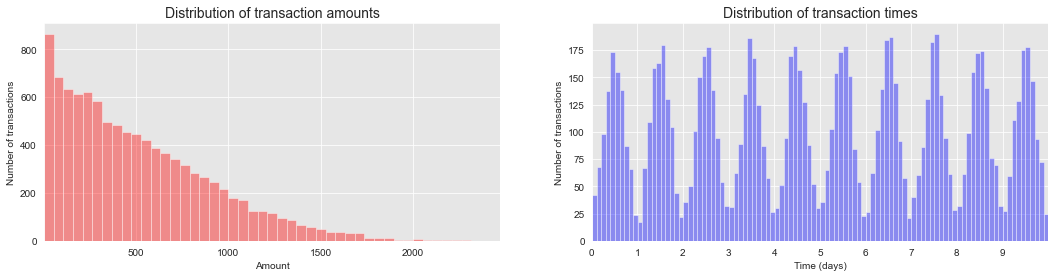

In [25]:
distribution_amount_times_fig

In [26]:
#print(transactions_df.style.to_latex(buf='transactions_df.tex'))

In [27]:
def add_frauds(customer_profiles_table, receiver_profiles_table, transactions_df):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
       
    # Scenario 1, black-lists, mules. RECEIVERS. LEGITIMATE CLIENT, FRAUDULENT RECEIVER OR IBAN
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_receivers = receiver_profiles_table.RECEIVER_ID.sample(n=2, random_state=day).values
        
        compromised_transactions=transactions_df[transactions_df.RECEIVER_ID.isin(compromised_receivers)]
        
        #nb_compromised_transactions=len(compromised_transactions)
                
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=1
                                  
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    #Scenario 2: phising cases, client account compromised
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_clients = customer_profiles_table.SENDER_ID.sample(n=5, random_state=day).values #5 clients compromised
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+5) & 
                                                    (transactions_df.SENDER_ID.isin(compromised_clients))] #their transactions are compromised 5 days
        
        nb_compromised_transactions=len(compromised_transactions)
        random.seed(day)
        index_ftx= random.sample(list(compromised_transactions.index.values), k=int(nb_compromised_transactions/4)) #25% of their transactions are fraudulent because they have their amounts *1.15
        
        #transactions_df.loc[transactions_df['TX_AMOUNT']<100, 'TX_FRAUD']= 1
        transactions_df.loc[index_ftx, 'TX_AMOUNT']= transactions_df.loc[index_ftx, 'TX_AMOUNT']*1.15
        transactions_df.loc[index_ftx, 'TX_FRAUD']=1
        transactions_df.loc[index_ftx, 'TX_FRAUD_SCENARIO']=2

        
        #if(transactions_df.get(['TX_AMOUNT'])>100 & transactions_df.get(['TX_AMOUNT'])<500):
         #   transactions_df.loc[index_ftx, 'TX_AMOUNT']*3
          #  transactions_df.loc[index_ftx, 'TX_FRAUD']=1
           # transactions_df.loc[index_ftx, 'TX_FRAUD_SCENARIO']=2
                                
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    
    #Scenario 3: client operating from a unknown ip --> potential fraud 
    
    #for day in range(transactions_df.TX_TIME_DAYS.max()):
     #   fraudulent_clients= customer_profiles_table.SENDER_ID.sample(n=5, random_state=day).values # 5 random ips are informed to be fraudulent    
      #  compromised_tx=transactions_df[(transactions_df.SENDER_ID.isin(fraudulent_clients))]
       # transactions_df.loc[compromised_tx.index,'TX_FRAUD']=1
        #transactions_df.loc[compromised_tx.index,'TX_FRAUD_SCENARIO']=3
        
    #nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2#-nb_frauds_scenario_1
    #print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    return transactions_df                 

In [28]:
%time transactions_df = add_frauds(customer_profiles_table, receiver_profiles_table, transactions_df)

Number of frauds from scenario 1: 4611500
Number of frauds from scenario 2: 10295
CPU times: total: 2h 4min 51s
Wall time: 16h 22min 53s


In [29]:
transactions_df.TX_FRAUD.mean()

0.30870981693337096

In [30]:
transactions_df.TX_FRAUD.sum()

4621795

In [31]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2017-09-05 00:00:31,1784,ES9759829751721016132037,3122,ES8948173133800584835158,337.89,31,0,0,0
1,1,2017-09-05 00:01:42,5199,ES0440942338489897396095,2949,ES8175034922683534700272,246.18,102,0,1,1
2,2,2017-09-05 00:01:59,3305,ES8357786516953523958581,4121,ES5738140145327875933422,842.95,119,0,1,1
3,3,2017-09-05 00:03:12,53,ES4932583861269516637636,1769,ES4140920575646842478395,501.8,192,0,0,0
4,4,2017-09-05 00:05:13,5290,ES9195762557442068820105,5292,PT52809944334055867249256,1352.13,313,0,0,0


In [32]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==2].shape

(14961, 11)

In [33]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==1].shape

(4606834, 11)

In [34]:
def get_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['SENDER_ID'].count()
    #print(nb_tx_per_day)
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudbt_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).SENDER_ID.nunique()
    
    return (nb_tx_per_day,nb_fraud_per_day,nb_fraudbt_per_day)

(nb_tx_per_day,nb_fraud_per_day,nb_fraudbt_per_day)=get_stats(transactions_df)

n_days=len(nb_tx_per_day)
tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day/50,nb_fraudbt_per_day/50])})
tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudbt_per_day"]*n_days
tx_stats=tx_stats.reset_index()

In [35]:
%%capture

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

fraud_and_transactions_stats_fig = plt.gcf()

fraud_and_transactions_stats_fig.set_size_inches(15, 8)

sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudbt_per_day"], legend=False)

sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of compromised transfers per day', fontsize=20)
sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")

sns_plot.set_ylim([0,500])

labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day (/50)", "# fraudulent transfers per day (/50)"]

sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)

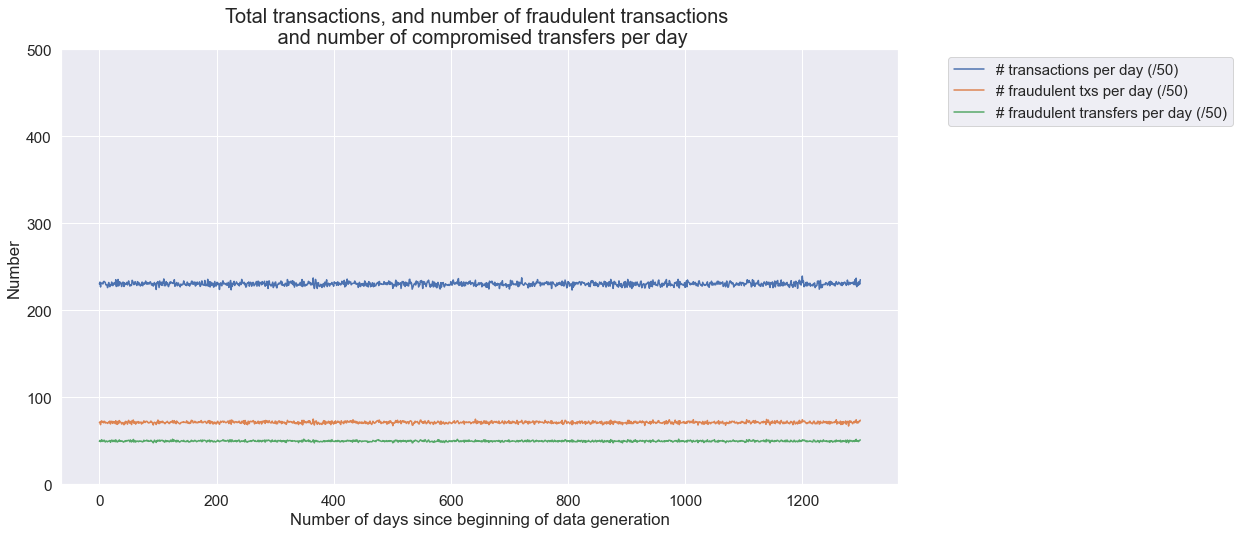

In [36]:
fraud_and_transactions_stats_fig

In [37]:
DIR_OUTPUT = "./simulated-data-raw/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2017-09-05", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

In [38]:
#print(transactions_df.style.to_latex(buf='transactions_df_frauds.tex'))

In [39]:
##transformations to the dataset -> features

In [40]:
# Load a set of pickle files, put them together in a single DataFrame, and order them by time
# It takes as input the folder DIR_INPUT where the files are stored, and the BEGIN_DATE and END_DATE
import pandas as pd

def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final

In [41]:
DIR_INPUT='./simulated-data-raw' 

BEGIN_DATE = "2017-09-05"
END_DATE = "2021-03-27"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: total: 3min 36s
Wall time: 5min 25s
14971325 transactions loaded, containing 4621795 fraudulent transactions


In [42]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2017-09-05 00:00:31,1784,ES9759829751721016132037,3122,ES8948173133800584835158,337.89,31,0,0,0
1,1,2017-09-05 00:01:42,5199,ES0440942338489897396095,2949,ES8175034922683534700272,246.18,102,0,1,1
2,2,2017-09-05 00:01:59,3305,ES8357786516953523958581,4121,ES5738140145327875933422,842.95,119,0,1,1
3,3,2017-09-05 00:03:12,53,ES4932583861269516637636,1769,ES4140920575646842478395,501.80,192,0,0,0
4,4,2017-09-05 00:05:13,5290,ES9195762557442068820105,5292,PT52809944334055867249256,1352.13,313,0,0,0


In [43]:
##date transformations -> occurs during wday or wend -> TX_DURING_WEEKEND
##                     -> occurs during day or night -> TX_DURING_NIGHT

In [44]:
## TX_DURING_WEEKEND feature
## 1 -> wend, 0 -> otherwise
def is_weekend(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

In [45]:
%time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)

CPU times: total: 45.8 s
Wall time: 48.8 s


In [46]:
## feature TX_DURING_NIGHT

In [47]:
## 1 -> night, 0 -> otherwise(day)
def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    
    return int(is_night)

In [48]:
%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

CPU times: total: 31.5 s
Wall time: 31.8 s


In [49]:
transactions_df[transactions_df.TX_TIME_DAYS>=30]

,TRANSACTION_ID,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT
345391,345391,2017-10-05 00:01:40,4889,ES3335207375791813481517,4834,ES1768344207755897842063,87.90,2592100,30,1,1,0,1
345392,345392,2017-10-05 00:02:33,1104,ES5651968204510912957602,5959,ES0760991527996255965090,1593.38,2592153,30,0,0,0,1
345393,345393,2017-10-05 00:02:59,447,ES7480417699589308441460,3643,ES3459706318849982160283,628.43,2592179,30,1,1,0,1
345394,345394,2017-10-05 00:04:29,622,ES7722598565027304222033,6536,ES4989336347514571268265,1016.54,2592269,30,0,0,0,1
345395,345395,2017-10-05 00:05:18,4625,ES0252230247611169528544,5815,ES7495180890947931096900,117.55,2592318,30,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14971320,14971320,2021-03-27 23:55:20,2918,ES2773122558832438113049,1946,ES7909479305218831430209,308.28,112319720,1299,0,0,1,0
14971321,14971321,2021-03-27 23:55:32,3450,ES4138200103980207933600,5189,IT32X1833657608933339558926,2.45,112319732,1299,0,0,1,0
14971322,14971322,2021-03-27 23:57:06,5038,ES8296015840077148604192,4423,PT98879803137106943747755,656.69,112319826,1299,0,0,1,0
14971323,14971323,2021-03-27 23:58:36,797,ES6046550614624604872552,5297,PT82474840602760796005646,98.95,112319916,1299,0,0,1,0


In [50]:
#transactions_df.style.to_latex(buf='tx_datefeature.tex')

In [51]:
##sender id transformations

In [52]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['SENDER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['SENDER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions

In [53]:
spending_behaviour_customer_0=get_customer_spending_behaviour_features(transactions_df[transactions_df.SENDER_ID==0])
spending_behaviour_customer_0

,TRANSACTION_ID,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,SENDER_ID_NB_TX_1DAY_WINDOW,SENDER_ID_AVG_AMOUNT_1DAY_WINDOW,SENDER_ID_NB_TX_7DAY_WINDOW,SENDER_ID_AVG_AMOUNT_7DAY_WINDOW,SENDER_ID_NB_TX_30DAY_WINDOW,SENDER_ID_AVG_AMOUNT_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,
2173,2173,2017-09-05 07:19:05,0,ES5937696069602714278789,6917,PT23960367006143394469582,1089.82,26345,0,0,0,0,0,1.0,1089.820000,1.0,1089.820000,1.0,1089.820000
10021,10021,2017-09-05 18:00:16,0,ES5937696069602714278789,3445,PT82939538786782041693769,681.99,64816,0,0,0,0,0,2.0,885.905000,2.0,885.905000,2.0,885.905000
10478,10478,2017-09-05 19:02:02,0,ES5937696069602714278789,3155,ES3252891106768290721065,410.17,68522,0,0,0,0,0,3.0,727.326667,3.0,727.326667,3.0,727.326667
14750,14750,2017-09-06 08:51:06,0,ES5937696069602714278789,3980,ES8140616497381209078454,482.56,118266,1,1,1,0,0,3.0,524.906667,4.0,666.135000,4.0,666.135000
19188,19188,2017-09-06 14:05:38,0,ES5937696069602714278789,2121,ES6749131598739172385371,558.22,137138,1,1,1,0,0,4.0,533.235000,5.0,644.552000,5.0,644.552000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14964170,14964170,2021-03-27 10:26:00,0,ES5937696069602714278789,5098,ES0437938156066130005591,644.78,112271160,1299,1,1,1,0,3.0,547.310000,18.0,568.019444,90.0,587.249778
14964290,14964290,2021-03-27 10:33:40,0,ES5937696069602714278789,6094,PT16089145064282776282712,19.37,112271620,1299,1,1,1,0,4.0,415.325000,19.0,539.143158,91.0,581.009341
14965808,14965808,2021-03-27 12:17:49,0,ES5937696069602714278789,3823,ES0615559091625560226122,703.56,112277869,1299,0,0,1,0,4.0,420.075000,20.0,547.364000,90.0,575.460333


In [54]:
%time transactions_df=transactions_df.groupby('SENDER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

CPU times: total: 3min 6s
Wall time: 4min 33s


In [55]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,SENDER_ID_NB_TX_1DAY_WINDOW,SENDER_ID_AVG_AMOUNT_1DAY_WINDOW,SENDER_ID_NB_TX_7DAY_WINDOW,SENDER_ID_AVG_AMOUNT_7DAY_WINDOW,SENDER_ID_NB_TX_30DAY_WINDOW,SENDER_ID_AVG_AMOUNT_30DAY_WINDOW
0,0,2017-09-05 00:00:31,1784,ES9759829751721016132037,3122,ES8948173133800584835158,337.89,31,0,0,0,0,1,1.0,337.890000,1.0,337.890000,1.0,337.890000
1,1,2017-09-05 00:01:42,5199,ES0440942338489897396095,2949,ES8175034922683534700272,246.18,102,0,1,1,0,1,1.0,246.180000,1.0,246.180000,1.0,246.180000
2,2,2017-09-05 00:01:59,3305,ES8357786516953523958581,4121,ES5738140145327875933422,842.95,119,0,1,1,0,1,1.0,842.950000,1.0,842.950000,1.0,842.950000
3,3,2017-09-05 00:03:12,53,ES4932583861269516637636,1769,ES4140920575646842478395,501.80,192,0,0,0,0,1,1.0,501.800000,1.0,501.800000,1.0,501.800000
4,4,2017-09-05 00:05:13,5290,ES9195762557442068820105,5292,PT52809944334055867249256,1352.13,313,0,0,0,0,1,1.0,1352.130000,1.0,1352.130000,1.0,1352.130000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14971320,14971320,2021-03-27 23:55:20,2918,ES2773122558832438113049,1946,ES7909479305218831430209,308.28,112319720,1299,0,0,1,0,4.0,334.812500,12.0,378.839167,36.0,376.488611
14971321,14971321,2021-03-27 23:55:32,3450,ES4138200103980207933600,5189,IT32X1833657608933339558926,2.45,112319732,1299,0,0,1,0,2.0,3.535000,15.0,4.037333,69.0,4.652029
14971322,14971322,2021-03-27 23:57:06,5038,ES8296015840077148604192,4423,PT98879803137106943747755,656.69,112319826,1299,0,0,1,0,3.0,874.026667,26.0,776.842692,118.0,745.921525
14971323,14971323,2021-03-27 23:58:36,797,ES6046550614624604872552,5297,PT82474840602760796005646,98.95,112319916,1299,0,0,1,0,2.0,60.700000,16.0,105.209375,91.0,101.637802


In [56]:
#transactions_df.style.to_latex(buf='tx_senderfeature')

In [57]:
##RECEIVER TRANSFORMATIONS
##DELAY PERIOD: TIME TO DISCOVER THE FRAUDULENT TRANSACTIONS, CUSTOMER COMPLAINT, OR INVESTIGATION. SET TO 1 WEEK FIRST

In [58]:
def get_count_risk_rolling_window(receiver_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="RECEIVER_ID"):
    
    receiver_transactions=receiver_transactions.sort_values('TX_DATETIME')
    
    receiver_transactions.index=receiver_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=receiver_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=receiver_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=receiver_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=receiver_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        receiver_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        receiver_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    receiver_transactions.index=receiver_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    receiver_transactions.fillna(0,inplace=True)
    
    return receiver_transactions

In [59]:
transactions_df[transactions_df.TX_FRAUD==1]

,TRANSACTION_ID,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,SENDER_ID_NB_TX_1DAY_WINDOW,SENDER_ID_AVG_AMOUNT_1DAY_WINDOW,SENDER_ID_NB_TX_7DAY_WINDOW,SENDER_ID_AVG_AMOUNT_7DAY_WINDOW,SENDER_ID_NB_TX_30DAY_WINDOW,SENDER_ID_AVG_AMOUNT_30DAY_WINDOW
1,1,2017-09-05 00:01:42,5199,ES0440942338489897396095,2949,ES8175034922683534700272,246.18,102,0,1,1,0,1,1.0,246.180000,1.0,246.180000,1.0,246.180000
2,2,2017-09-05 00:01:59,3305,ES8357786516953523958581,4121,ES5738140145327875933422,842.95,119,0,1,1,0,1,1.0,842.950000,1.0,842.950000,1.0,842.950000
5,5,2017-09-05 00:05:18,5680,ES2484628187041888126237,848,ES0689839243618988103919,270.39,318,0,1,1,0,1,1.0,270.390000,1.0,270.390000,1.0,270.390000
12,12,2017-09-05 00:11:08,5216,ES5147192286270967094607,479,PT76148930820780053350375,116.10,668,0,1,1,0,1,1.0,116.100000,1.0,116.100000,1.0,116.100000
19,19,2017-09-05 00:14:37,3679,ES5473360959110258874795,2277,PT72450646478836635183153,232.45,877,0,1,1,0,1,1.0,232.450000,1.0,232.450000,1.0,232.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14971309,14971309,2021-03-27 23:49:56,3804,ES9473002616883249034389,546,PT18298370874341796616752,0.95,112319396,1299,1,1,1,0,4.0,1.775000,25.0,2.669200,77.0,2.495325
14971310,14971310,2021-03-27 23:50:28,5747,ES7160279769842435340659,2236,ES4952949682507550414074,1006.51,112319428,1299,1,1,1,0,4.0,833.537500,21.0,722.944762,87.0,643.306782
14971311,14971311,2021-03-27 23:51:03,132,ES7085053606842404156043,5598,ES4964885344521324132280,713.81,112319463,1299,1,1,1,0,4.0,725.172500,23.0,682.464348,82.0,666.553659
14971313,14971313,2021-03-27 23:52:24,367,ES8310425733453227372254,3580,ES8524682251202537810083,960.47,112319544,1299,1,1,1,0,3.0,674.326667,21.0,542.230952,89.0,507.309551


In [60]:
# Get the first RECEIVER ID that contains frauds
transactions_df[transactions_df.TX_FRAUD==0].RECEIVER_ID[0]

3122

In [61]:
get_count_risk_rolling_window(transactions_df[transactions_df.RECEIVER_ID==3059], delay_period=7, windows_size_in_days=[1,7,30])

,TRANSACTION_ID,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,...,SENDER_ID_NB_TX_7DAY_WINDOW,SENDER_ID_AVG_AMOUNT_7DAY_WINDOW,SENDER_ID_NB_TX_30DAY_WINDOW,SENDER_ID_AVG_AMOUNT_30DAY_WINDOW,RECEIVER_ID_NB_TX_1DAY_WINDOW,RECEIVER_ID_RISK_1DAY_WINDOW,RECEIVER_ID_NB_TX_7DAY_WINDOW,RECEIVER_ID_RISK_7DAY_WINDOW,RECEIVER_ID_NB_TX_30DAY_WINDOW,RECEIVER_ID_RISK_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,,,
19260,19260,2017-09-06 14:12:13,3839,ES0427635522301013474904,3059,PT92050554445492625108691,56.49,137533,1,0,...,5.0,67.270000,5.0,67.270000,0.0,0.0,0.0,0.0,0.0,0.0
22390,22390,2017-09-06 19:48:39,2629,ES1381911386162876681742,3059,PT92050554445492625108691,529.21,157719,1,0,...,8.0,659.113750,8.0,659.113750,0.0,0.0,0.0,0.0,0.0,0.0
52738,52738,2017-09-09 12:59:28,135,ES6026673412904212426486,3059,PT92050554445492625108691,86.92,392368,4,0,...,16.0,1002.817500,16.0,1002.817500,0.0,0.0,0.0,0.0,0.0,0.0
53704,53704,2017-09-09 14:11:44,3932,ES6170461534644446911962,3059,PT92050554445492625108691,760.26,396704,4,0,...,11.0,1007.995455,11.0,1007.995455,0.0,0.0,0.0,0.0,0.0,0.0
55025,55025,2017-09-09 16:01:02,3579,ES9206163970224760225230,3059,PT92050554445492625108691,58.60,403262,4,0,...,3.0,43.783333,3.0,43.783333,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14943717,14943717,2021-03-25 13:48:28,414,ES4245175949393913540376,3059,PT92050554445492625108691,1432.79,112110508,1297,0,...,4.0,831.495000,16.0,772.331250,3.0,0.0,12.0,0.0,60.0,0.0
14952886,14952886,2021-03-26 10:55:47,645,ES0434152530966116988108,3059,PT92050554445492625108691,740.88,112186547,1298,0,...,23.0,356.283913,123.0,331.399106,2.0,0.0,13.0,0.0,61.0,0.0
14958833,14958833,2021-03-26 19:51:53,5405,ES9498455049916359773237,3059,PT92050554445492625108691,804.44,112218713,1298,0,...,10.0,354.136000,61.0,441.210328,1.0,0.0,13.0,0.0,59.0,0.0


In [62]:
%time transactions_df=transactions_ df.groupby('RECEIVER_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="RECEIVER_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,...,SENDER_ID_NB_TX_7DAY_WINDOW,SENDER_ID_AVG_AMOUNT_7DAY_WINDOW,SENDER_ID_NB_TX_30DAY_WINDOW,SENDER_ID_AVG_AMOUNT_30DAY_WINDOW,RECEIVER_ID_NB_TX_1DAY_WINDOW,RECEIVER_ID_RISK_1DAY_WINDOW,RECEIVER_ID_NB_TX_7DAY_WINDOW,RECEIVER_ID_RISK_7DAY_WINDOW,RECEIVER_ID_NB_TX_30DAY_WINDOW,RECEIVER_ID_RISK_30DAY_WINDOW
0,0,2017-09-05 00:00:31,1784,ES9759829751721016132037,3122,ES8948173133800584835158,337.89,31,0,0,...,1.0,337.890000,1.0,337.890000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,1,2017-09-05 00:01:42,5199,ES0440942338489897396095,2949,ES8175034922683534700272,246.18,102,0,1,...,1.0,246.180000,1.0,246.180000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,2,2017-09-05 00:01:59,3305,ES8357786516953523958581,4121,ES5738140145327875933422,842.95,119,0,1,...,1.0,842.950000,1.0,842.950000,0.0,0.0,0.0,0.000000,0.0,0.000000
3,3,2017-09-05 00:03:12,53,ES4932583861269516637636,1769,ES4140920575646842478395,501.80,192,0,0,...,1.0,501.800000,1.0,501.800000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,4,2017-09-05 00:05:13,5290,ES9195762557442068820105,5292,PT52809944334055867249256,1352.13,313,0,0,...,1.0,1352.130000,1.0,1352.130000,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14971320,14971320,2021-03-27 23:55:20,2918,ES2773122558832438113049,1946,ES7909479305218831430209,308.28,112319720,1299,0,...,12.0,378.839167,36.0,376.488611,0.0,0.0,14.0,0.000000,47.0,0.000000
14971321,14971321,2021-03-27 23:55:32,3450,ES4138200103980207933600,5189,IT32X1833657608933339558926,2.45,112319732,1299,0,...,15.0,4.037333,69.0,4.652029,0.0,0.0,6.0,0.000000,46.0,0.000000
14971322,14971322,2021-03-27 23:57:06,5038,ES8296015840077148604192,4423,PT98879803137106943747755,656.69,112319826,1299,0,...,26.0,776.842692,118.0,745.921525,4.0,0.0,14.0,0.000000,53.0,0.000000
14971323,14971323,2021-03-27 23:58:36,797,ES6046550614624604872552,5297,PT82474840602760796005646,98.95,112319916,1299,0,...,16.0,105.209375,91.0,101.637802,4.0,0.0,21.0,0.047619,53.0,0.018868


In [ ]:
#print(transactions_df.style.to_latex())

NameError: name 'transactions_df' is not defined

In [ ]:
#import datetime 
#DIR_OUTPUT = "./simulated-data-transformed/"

#if not os.path.exists(DIR_OUTPUT):
 #   os.makedirs(DIR_OUTPUT)

#start_date = datetime.datetime.strptime("2017-09-05", "%Y-%m-%d")

#for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
 #   transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
  #  
   # date = start_date + datetime.timedelta(days=day)
    #filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    #
    # Protocol=4 required for Google Colab
    #transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

NameError: name 'transactions_df' is not defined

In [ ]:
# Load data from the 2018-07-25 to the 2018-08-14

#DIR_INPUT='./simulated-data-transformed' 

#BEGIN_DATE = "2017-09-05"
#END_DATE = "2021-03-27"

#print("Load  files")
#%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
#print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files


NameError: name 'read_from_files' is not defined

NameError: name 'transactions_df' is not defined

In [ ]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,SENDER_ID,SENDER_IBAN,RECEIVER_ID,RECEIVER_IBAN,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,...,SENDER_ID_NB_TX_7DAY_WINDOW,SENDER_ID_AVG_AMOUNT_7DAY_WINDOW,SENDER_ID_NB_TX_30DAY_WINDOW,SENDER_ID_AVG_AMOUNT_30DAY_WINDOW,RECEIVER_ID_NB_TX_1DAY_WINDOW,RECEIVER_ID_RISK_1DAY_WINDOW,RECEIVER_ID_NB_TX_7DAY_WINDOW,RECEIVER_ID_RISK_7DAY_WINDOW,RECEIVER_ID_NB_TX_30DAY_WINDOW,RECEIVER_ID_RISK_30DAY_WINDOW
0,0,2017-09-05 00:00:31,1784,ES9759829751721016132037,3122,ES8948173133800584835158,337.89,31,0,0,...,1.0,337.890000,1.0,337.890000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,1,2017-09-05 00:01:42,5199,ES0440942338489897396095,2949,ES8175034922683534700272,246.18,102,0,1,...,1.0,246.180000,1.0,246.180000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,2,2017-09-05 00:01:59,3305,ES8357786516953523958581,4121,ES5738140145327875933422,842.95,119,0,1,...,1.0,842.950000,1.0,842.950000,0.0,0.0,0.0,0.000000,0.0,0.000000
3,3,2017-09-05 00:03:12,53,ES4932583861269516637636,1769,ES4140920575646842478395,501.80,192,0,0,...,1.0,501.800000,1.0,501.800000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,4,2017-09-05 00:05:13,5290,ES9195762557442068820105,5292,PT52809944334055867249256,1352.13,313,0,0,...,1.0,1352.130000,1.0,1352.130000,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14971320,14971320,2021-03-27 23:55:20,2918,ES2773122558832438113049,1946,ES7909479305218831430209,308.28,112319720,1299,0,...,12.0,378.839167,36.0,376.488611,0.0,0.0,14.0,0.000000,47.0,0.000000
14971321,14971321,2021-03-27 23:55:32,3450,ES4138200103980207933600,5189,IT32X1833657608933339558926,2.45,112319732,1299,0,...,15.0,4.037333,69.0,4.652029,0.0,0.0,6.0,0.000000,46.0,0.000000
14971322,14971322,2021-03-27 23:57:06,5038,ES8296015840077148604192,4423,PT98879803137106943747755,656.69,112319826,1299,0,...,26.0,776.842692,118.0,745.921525,4.0,0.0,14.0,0.000000,53.0,0.000000
14971323,14971323,2021-03-27 23:58:36,797,ES6046550614624604872552,5297,PT82474840602760796005646,98.95,112319916,1299,0,...,16.0,105.209375,91.0,101.637802,4.0,0.0,21.0,0.047619,53.0,0.018868


In [ ]:
#print(transactions_df.style.to_latex())

\begin{tabular}{lrlrlrlrrrrrrrrrrrrrrrrrrr}
 & TRANSACTION_ID & TX_DATETIME & SENDER_ID & SENDER_IBAN & RECEIVER_ID & RECEIVER_IBAN & TX_AMOUNT & TX_TIME_SECONDS & TX_TIME_DAYS & TX_FRAUD & TX_FRAUD_SCENARIO & TX_DURING_WEEKEND & TX_DURING_NIGHT & SENDER_ID_NB_TX_1DAY_WINDOW & SENDER_ID_AVG_AMOUNT_1DAY_WINDOW & SENDER_ID_NB_TX_7DAY_WINDOW & SENDER_ID_AVG_AMOUNT_7DAY_WINDOW & SENDER_ID_NB_TX_30DAY_WINDOW & SENDER_ID_AVG_AMOUNT_30DAY_WINDOW & RECEIVER_ID_NB_TX_1DAY_WINDOW & RECEIVER_ID_RISK_1DAY_WINDOW & RECEIVER_ID_NB_TX_7DAY_WINDOW & RECEIVER_ID_RISK_7DAY_WINDOW & RECEIVER_ID_NB_TX_30DAY_WINDOW & RECEIVER_ID_RISK_30DAY_WINDOW \\
0 & 0 & 2017-09-05 00:00:31 & 1784 & ES9759829751721016132037 & 3122 & ES8948173133800584835158 & 337.890000 & 31 & 0 & 0 & 0 & 0 & 1 & 1.000000 & 337.890000 & 1.000000 & 337.890000 & 1.000000 & 337.890000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
1 & 1 & 2017-09-05 00:01:42 & 5199 & ES0440942338489897396095 & 2949 & ES817503492268353